# 다중 선형 회귀

In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential      # 순서층을 구성하는 모델 객체 생성 기능
from tensorflow.keras.layers import Dense           # 모델 객체에 학습을 위한 층을 쌓는다.
from tensorflow.keras.optimizers import RMSprop,SGD # 옵티마이저
from tensorflow.keras.losses import mse             # 활성화 함수
import pandas as pd 
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
import helper


from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 학습에 대한 콜백함수 참조
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

## #02. 데이터 준비

In [2]:
origin = pd.read_excel('https://data.hossam.kr/E04/boston.xlsx')
origin.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0,0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6,0
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7,1
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4,1
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2,1


## #03. 데이터 전처리

In [3]:
origin.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,0.166008
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.372456
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,0.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,0.000000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,0.000000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,0.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.000000


In [4]:
origin.isnull().sum()

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
MEDV         0
CAT. MEDV    0
dtype: int64

### 상자그림


<Axes: >

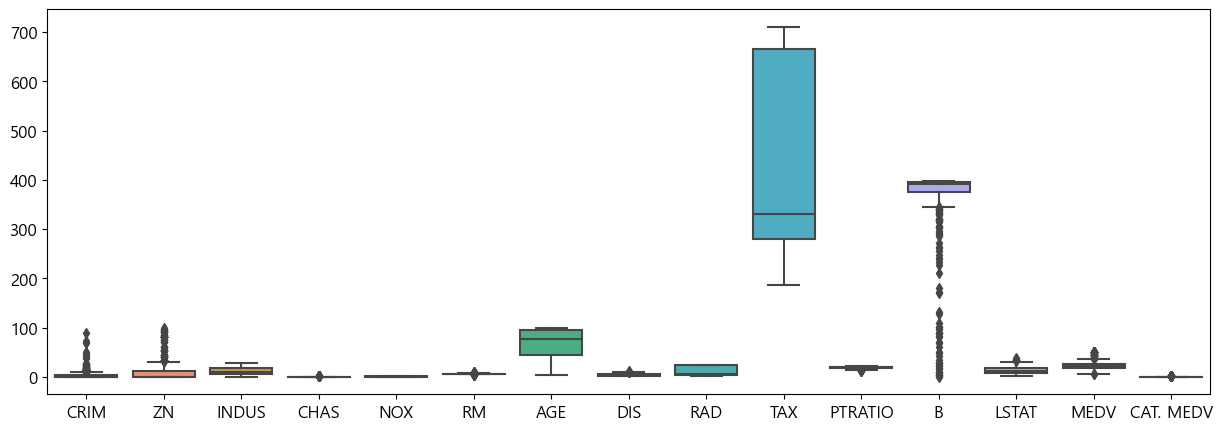

In [36]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(15,5))
sns.boxplot(data=origin)

> 표준화 필요

> CAT.MEDV, CHAS 범주형

In [37]:
origin.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806,0.166008
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104,0.372456
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000,0.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000,0.000000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000,0.000000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000,0.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000,1.000000


In [38]:
corr_col = origin.corr().iloc[:,-2].abs().sort_values(ascending=False)[1:]
corr_col

CAT. MEDV    0.789789
LSTAT        0.737663
RM           0.695360
PTRATIO      0.507787
INDUS        0.483725
TAX          0.468536
NOX          0.427321
CRIM         0.388305
RAD          0.381626
AGE          0.376955
ZN           0.360445
B            0.333461
DIS          0.249929
CHAS         0.175260
Name: MEDV, dtype: float64

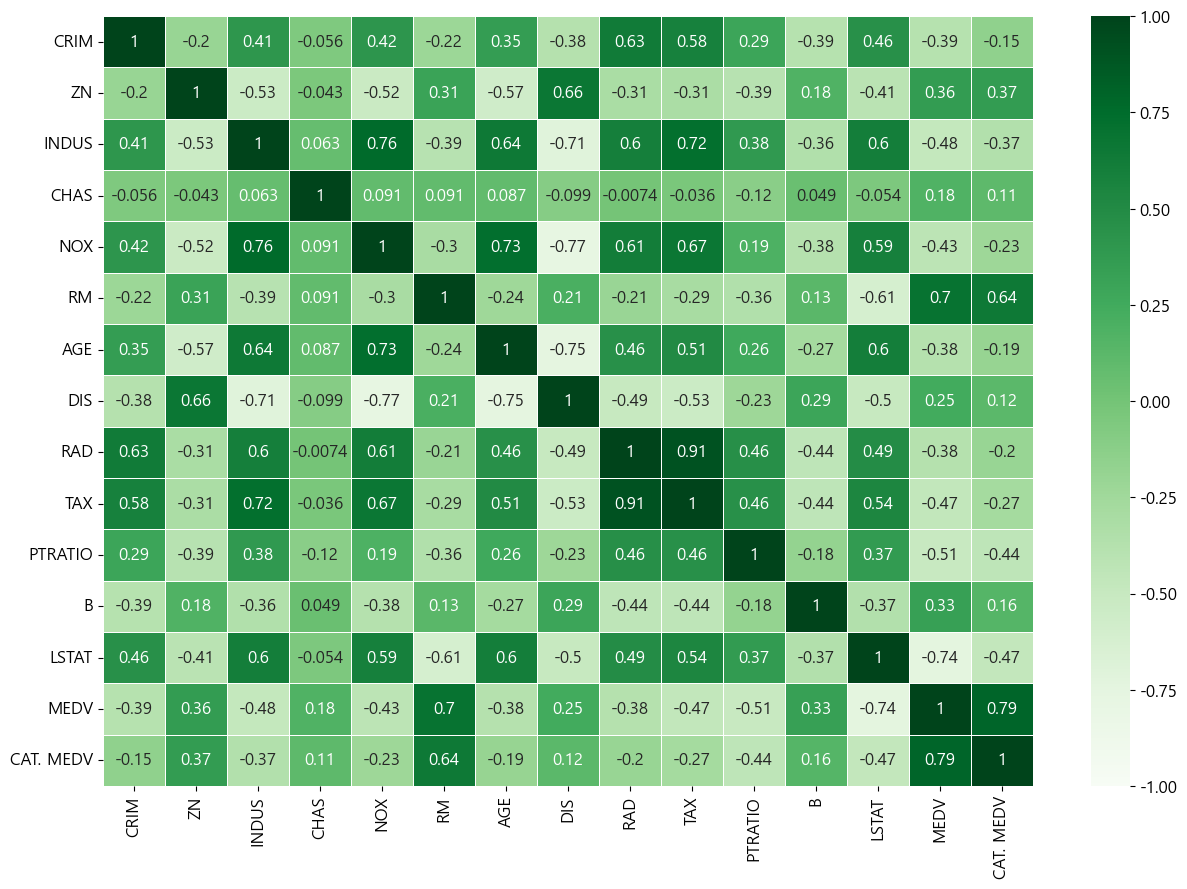

<function matplotlib.pyplot.close(fig=None)>

In [40]:
plt.figure(figsize=(15,10))
sns.heatmap(origin.corr(),annot=True,cmap='Greens',vmin=-1,vmax=1,linewidths=0.5)
plt.show()
plt.close

In [ ]:
### 

In [8]:
## 범주형 변수 처리 

df= origin.copy()
df.loc[:,['CHAS','CAT. MEDV']] = df.loc[:,['CHAS','CAT. MEDV']].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   CRIM       506 non-null    float64 
 1   ZN         506 non-null    float64 
 2   INDUS      506 non-null    float64 
 3   CHAS       506 non-null    category
 4   NOX        506 non-null    float64 
 5   RM         506 non-null    float64 
 6   AGE        506 non-null    float64 
 7   DIS        506 non-null    float64 
 8   RAD        506 non-null    int64   
 9   TAX        506 non-null    int64   
 10  PTRATIO    506 non-null    float64 
 11  B          506 non-null    float64 
 12  LSTAT      506 non-null    float64 
 13  MEDV       506 non-null    float64 
 14  CAT. MEDV  506 non-null    category
dtypes: category(2), float64(11), int64(2)
memory usage: 52.7 KB


### 데이터 표준화

In [10]:

num_col = ['CRIM', 'ZN', 'INDUS',  'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']

In [11]:
scaler = StandardScaler()
df.loc[:,num_col] = scaler.fit_transform(df.loc[:,num_col])
df.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CAT. MEDV
0,-0.419782,0.284830,-1.287909,0,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0,0
1,-0.417339,-0.487722,-0.593381,0,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6,0
2,-0.417342,-0.487722,-0.593381,0,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7,1
3,-0.416750,-0.487722,-1.306878,0,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4,1
4,-0.412482,-0.487722,-1.306878,0,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2,1


### 더미변수 

In [12]:

df = pd.get_dummies(df,drop_first=True,dtype='int')
df.head()


,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,CHAS_1,CAT. MEDV_1
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,24.0,0,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,21.6,0,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,34.7,0,1
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,33.4,0,1
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,36.2,0,1


### 독립변수 종속변수 분리

In [13]:
y = df[['MEDV']]
x = df.drop('MEDV',axis=1)
print(x.shape,y.shape)

(506, 14) (506, 1)


## #05. 데이터 분할

### 랜덤시드 고정

In [14]:
np.random.seed(777)

In [15]:
x.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1,CAT. MEDV_1
0,-0.419782,0.284830,-1.287909,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0,0
1,-0.417339,-0.487722,-0.593381,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,0,0
2,-0.417342,-0.487722,-0.593381,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,0,1
3,-0.416750,-0.487722,-1.306878,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,0,1
4,-0.412482,-0.487722,-1.306878,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,0,1


In [16]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=777)
print(len(y_train),len(x_test))


354 152


In [41]:
x_test.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1,CAT. MEDV_1
207,-0.391193,-0.487722,-0.079780,-0.567496,-0.714658,0.146691,0.266139,-0.637962,-0.779455,0.066796,0.359148,0.757911,0,0
425,1.425197,-0.487722,1.015999,1.073787,-0.553671,0.953916,-0.896281,1.661245,1.530926,0.806576,-3.826496,1.645211,0,0
408,0.441097,-0.487722,1.015999,0.365444,-0.951151,1.042817,-1.112527,1.661245,1.530926,0.806576,-0.460876,1.926960,0,0
63,-0.405796,0.585267,-0.876445,-0.878475,0.680083,-0.895234,1.989827,-0.178120,-0.737880,0.575395,0.426579,-0.441977,0,0
290,-0.416442,2.945843,-0.902709,-1.241285,0.821124,-1.446423,0.628275,-0.637962,-0.969512,0.344213,0.441052,-1.306849,0,0


<Axes: >

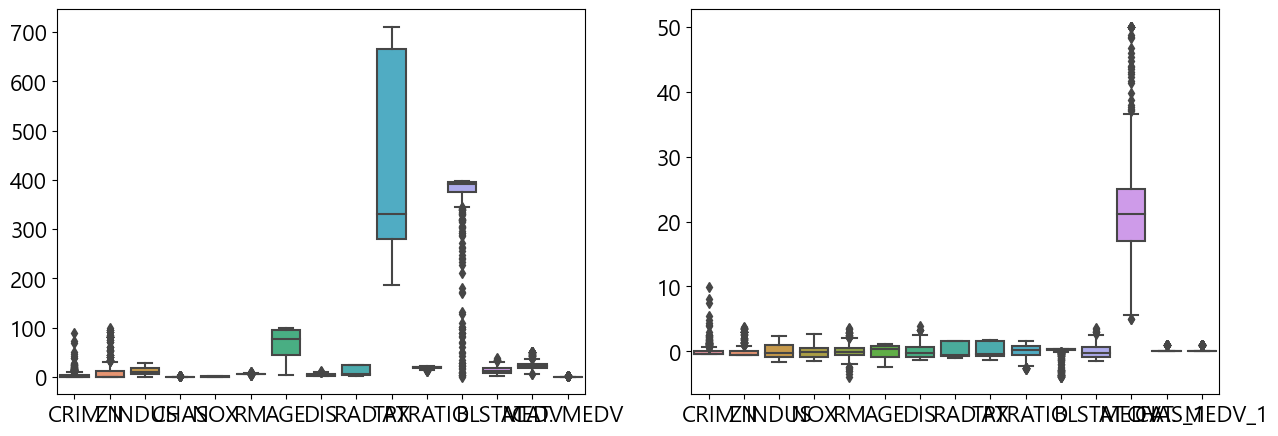

In [17]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.boxplot(data=origin,ax=ax[0])
sns.boxplot(data=df,ax=ax[1])

## #06.모델개발
### 1.모델 정의

In [18]:
x_train.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1,CAT. MEDV_1
372,0.541569,-0.487722,1.015999,0.978765,-0.583589,0.747665,-1.267069,1.661245,1.530926,0.806576,-0.096421,-0.528885,1,1
18,-0.327103,-0.487722,-0.437258,-0.144217,-1.180521,-1.137046,0.000693,-0.637962,-0.601276,1.176466,-0.742112,-0.134996,0,0
185,-0.413480,-0.487722,-1.266023,-0.576134,-0.187534,0.008005,-0.244978,-0.752922,-1.278354,-0.303094,0.333711,0.069658,0,0
57,-0.418851,3.804234,-1.432360,-1.241285,0.757015,-0.998360,2.153307,-0.523001,-0.904180,-1.551473,0.397194,-1.219941,0,1
261,-0.358360,0.370669,-1.045700,0.797361,1.759974,0.740552,-0.786851,-0.523001,-0.856665,-2.522434,0.347526,-0.755966,0,1


In [21]:
model = Sequential()
model.add(Dense(28,activation = 'relu',input_shape=(14,)))
model.add(Dense(14,activation = 'relu'))
model.add(Dense(1,activation='linear'))

model.compile(optimizer='adam',loss='mse',metrics = ['mae'])
model.summary

<bound method Model.summary of <keras.src.engine.sequential.Sequential object at 0x0000026619FB4F10>>

### 2. 학습하기

In [22]:
result= model.fit(x_train,y_train, epochs=500,validation_data = (x_test,y_test),callbacks=[
    EarlyStopping(monitor='val_loss',patience=10,verbose=1),
    ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.5,min_lir=0.0001,verbose=1),
    ])



result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index + 1
result_df.set_index('epochs',inplace=True)
result_df

Epoch 1/500
12/12 [==============================] - 2s 32ms/step - loss: 571.5025 - mae: 22.0544 - val_loss: 550.8459 - val_mae: 21.5551 - lr: 0.0010
Epoch 2/500
12/12 [==============================] - 0s 15ms/step - loss: 554.0547 - mae: 21.6592 - val_loss: 533.7604 - val_mae: 21.1485 - lr: 0.0010
Epoch 3/500
12/12 [==============================] - 0s 10ms/step - loss: 535.8713 - mae: 21.2324 - val_loss: 514.3682 - val_mae: 20.6823 - lr: 0.0010
Epoch 4/500
12/12 [==============================] - 0s 10ms/step - loss: 514.6834 - mae: 20.7323 - val_loss: 492.3138 - val_mae: 20.1373 - lr: 0.0010
Epoch 5/500
12/12 [==============================] - 0s 9ms/step - loss: 490.2059 - mae: 20.1435 - val_loss: 465.7668 - val_mae: 19.4676 - lr: 0.0010
Epoch 6/500
12/12 [==============================] - 0s 8ms/step - loss: 460.9879 - mae: 19.4328 - val_loss: 435.1292 - val_mae: 18.6726 - lr: 0.0010
Epoch 7/500
12/12 [==============================] - 0s 12ms/step - loss: 427.1194 - mae: 18.560

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,571.502502,22.054380,550.845947,21.555084,0.001000
2,554.054688,21.659212,533.760376,21.148504,0.001000
3,535.871277,21.232382,514.368164,20.682306,0.001000
4,514.683411,20.732347,492.313843,20.137341,0.001000
5,490.205902,20.143538,465.766846,19.467644,0.001000
...,...,...,...,...,...
172,9.089668,2.197673,13.768691,2.912394,0.000016
173,9.088146,2.197443,13.767381,2.912205,0.000008
174,9.088400,2.197550,13.765864,2.912062,0.000008


### 7) 학습 결과 평가
#### 1. 학습결과 시각화

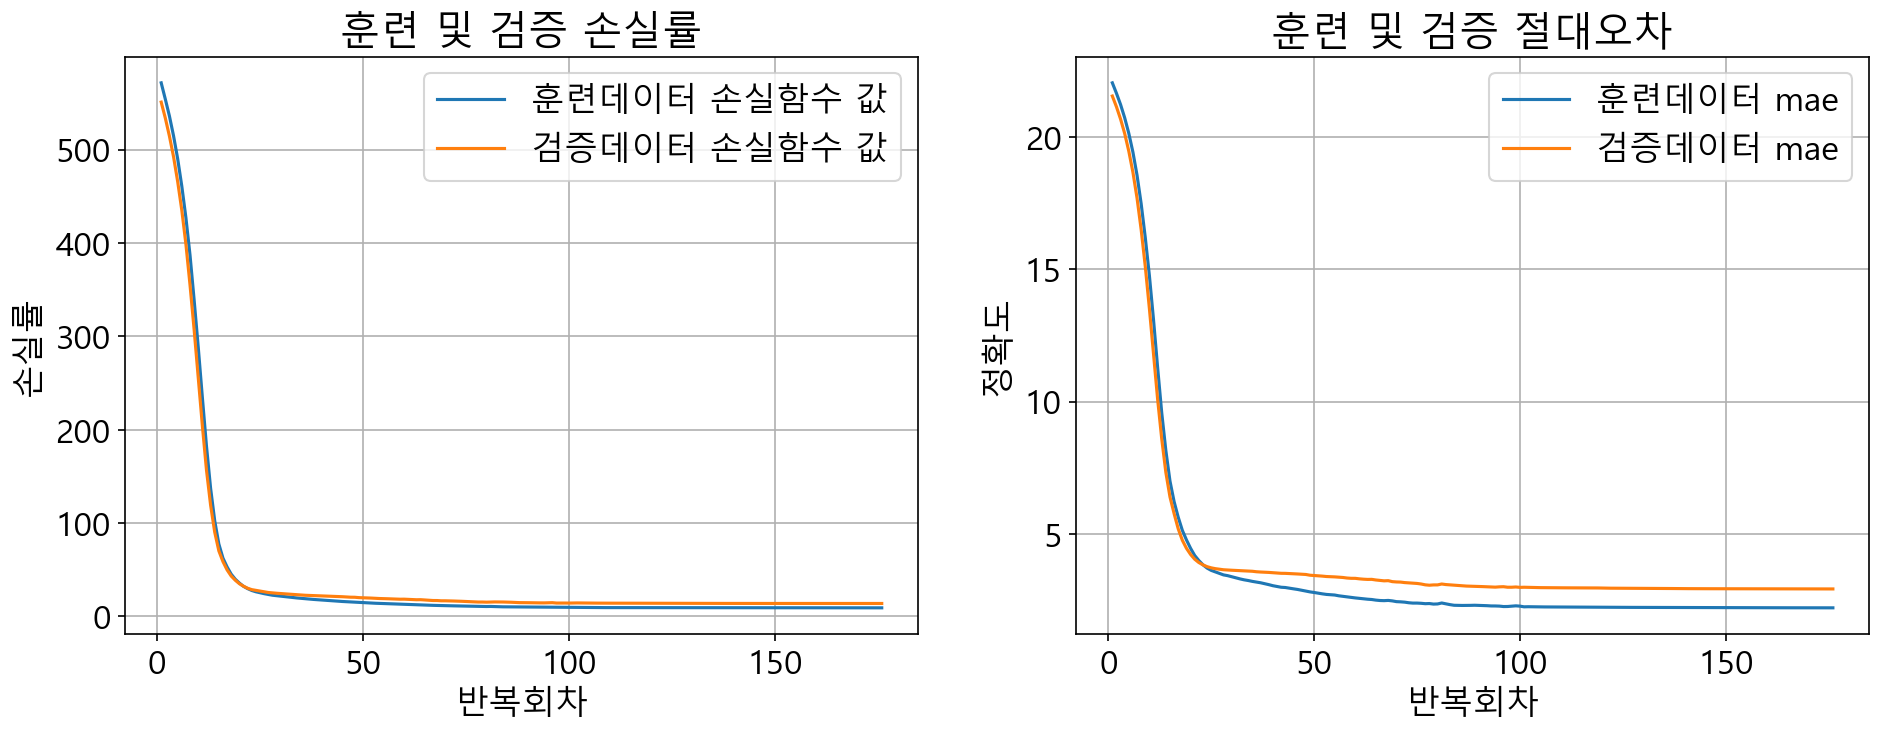

In [23]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sns.lineplot(x=result_df.index , y='loss',data = result_df,label = '훈련데이터 손실함수 값',ax=ax1)
sns.lineplot(x=result_df.index , y= 'val_loss',data=result_df,label = '검증데이터 손실함수 값',ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()
# 2) 훈련 및 검증 절대오차 그리기
sns.lineplot(x=result_df.index,y='mae',data=result_df,label='훈련데이터 mae',ax=ax2)
sns.lineplot(x=result_df.index,y='val_mae',data=result_df,label='검증데이터 mae',ax=ax2)

ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

#### 2. 모델 성능 평가

In [24]:
evaluate1 = model.evaluate(x_train,y_train)

evaluate2 = model.evaluate(x_test,y_test)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate2[0], evaluate2[1]))



5/5 [==============================] - 0s 4ms/step - loss: 13.7638 - mae: 2.9119
최종 훈련 손실률: 9.086812, 최종 훈련 절대오차: 2.197456
최종 훈련 손실률: 13.763808, 최종 훈련 절대오차: 2.911913


## #08. 학습 결과 적용
### 1. 테스트 데이터에 대한 예측 결과 산정

In [25]:
results = model.predict(x_test)
print(results)

5/5 [==============================] - 0s 1ms/step
[[16.15404  ]
 [ 9.966292 ]
 [15.264687 ]
 [19.344505 ]
 [29.019726 ]
 [18.492838 ]
 [17.383644 ]
 [42.9735   ]
 [12.809277 ]
 [44.989002 ]
 [27.171894 ]
 [23.054712 ]
 [11.938857 ]
 [22.225382 ]
 [16.759459 ]
 [35.52312  ]
 [ 7.3504   ]
 [21.450085 ]
 [22.979975 ]
 [14.56881  ]
 [16.44306  ]
 [18.614918 ]
 [ 8.574671 ]
 [24.717983 ]
 [14.772271 ]
 [25.456059 ]
 [24.145359 ]
 [29.362852 ]
 [21.025503 ]
 [21.029646 ]
 [25.820549 ]
 [33.315952 ]
 [23.262056 ]
 [26.346941 ]
 [25.562918 ]
 [26.345442 ]
 [13.175796 ]
 [25.49838  ]
 [17.164158 ]
 [17.498781 ]
 [22.133625 ]
 [15.644329 ]
 [12.729463 ]
 [15.731949 ]
 [14.956548 ]
 [22.617289 ]
 [ 9.718523 ]
 [23.020468 ]
 [14.736965 ]
 [18.332218 ]
 [30.674192 ]
 [38.488983 ]
 [16.379305 ]
 [19.566195 ]
 [15.968076 ]
 [18.2031   ]
 [18.764008 ]
 [13.400322 ]
 [26.625967 ]
 [16.11506  ]
 [24.7335   ]
 [17.570261 ]
 [23.489143 ]
 [11.672386 ]
 [21.647064 ]
 [36.668488 ]
 [37.321846 ]
 [19.741455

### 2. 결과 데이터 구성

In [26]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

 1/12 [=>............................] - ETA: 0s

5/5 [==============================] - 0s 2ms/step


In [28]:
train_df = pd.DataFrame(x_train,columns =x_train.columns)
train_df['무게(관측치)'] = y_train
train_df['무게(예측치)'] = train_pred

train_df['훈련오차'] = train_df['무게(관측치)'] - train_df['무게(예측치)']

train_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1,CAT. MEDV_1,무게(관측치),무게(예측치),훈련오차
372,0.541569,-0.487722,1.015999,0.978765,-0.583589,0.747665,-1.267069,1.661245,1.530926,0.806576,-0.096421,-0.528885,1,1,50.0,33.676453,16.323547
18,-0.327103,-0.487722,-0.437258,-0.144217,-1.180521,-1.137046,0.000693,-0.637962,-0.601276,1.176466,-0.742112,-0.134996,0,0,20.2,18.049810,2.150190
185,-0.413480,-0.487722,-1.266023,-0.576134,-0.187534,0.008005,-0.244978,-0.752922,-1.278354,-0.303094,0.333711,0.069658,0,0,29.6,23.177389,6.422611
57,-0.418851,3.804234,-1.432360,-1.241285,0.757015,-0.998360,2.153307,-0.523001,-0.904180,-1.551473,0.397194,-1.219941,0,1,31.6,32.780098,-1.180098
261,-0.358360,0.370669,-1.045700,0.797361,1.759974,0.740552,-0.786851,-0.523001,-0.856665,-2.522434,0.347526,-0.755966,0,1,43.1,38.917473,4.182527


In [30]:
test_df = pd.DataFrame(x_test,columns = x_test.columns)
test_df['무게(관측치)'] = y_test
test_df['무게(예측치)'] = test_pred

test_df['훈련오차'] = test_df['무게(관측치)'] - test_df['무게(예측치)']

test_df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS_1,CAT. MEDV_1,무게(관측치),무게(예측치),훈련오차
207,-0.391193,-0.487722,-0.079780,-0.567496,-0.714658,0.146691,0.266139,-0.637962,-0.779455,0.066796,0.359148,0.757911,0,0,22.5,16.154039,6.345961
425,1.425197,-0.487722,1.015999,1.073787,-0.553671,0.953916,-0.896281,1.661245,1.530926,0.806576,-3.826496,1.645211,0,0,8.3,9.966292,-1.666292
408,0.441097,-0.487722,1.015999,0.365444,-0.951151,1.042817,-1.112527,1.661245,1.530926,0.806576,-0.460876,1.926960,0,0,17.2,15.264687,1.935313
63,-0.405796,0.585267,-0.876445,-0.878475,0.680083,-0.895234,1.989827,-0.178120,-0.737880,0.575395,0.426579,-0.441977,0,0,25.0,19.344505,5.655495
290,-0.416442,2.945843,-0.902709,-1.241285,0.821124,-1.446423,0.628275,-0.637962,-0.969512,0.344213,0.441052,-1.306849,0,0,28.5,29.019726,-0.519726


### 3. 실제 결과값과 머신러닝에 의한 예측값 비교

In [32]:
# fig,ax = plt.subplots(3,2,figsize=(15,15))
# ## 관측치 시각화
# sns.scatterplot(x=train_df['길이'],y=train_df['무게(관측치)'],label = 'train data',ax=ax[0][0])
# # ## 관측치 선그래프
# sns.regplot(x=train_df['길이'],y=train_df['무게(예측치)'],ax=ax[0][0],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=train_df['높이'],y=train_df['무게(관측치)'],label = 'train data',ax=ax[1][0])
# # ## 관측치 선그래프
# sns.regplot(x=train_df['높이'],y=train_df['무게(예측치)'],ax=ax[1][0],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=train_df['두께'],y=train_df['무게(관측치)'],label = 'train data',ax=ax[2][0])
# # ## 관측치 선그래프
# sns.regplot(x=train_df['두께'],y=train_df['무게(예측치)'],ax=ax[2][0],color='red')

# ## 관측치 시각화
# sns.scatterplot(x=test_df['길이'],y=test_df['무게(관측치)'],label = 'train data',ax=ax[0][1])
# # ## 관측치 선그래프
# sns.regplot(x=test_df['길이'],y=test_df['무게(예측치)'],ax=ax[0][1],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=test_df['높이'],y=test_df['무게(관측치)'],label = 'train data',ax=ax[1][1])
# # ## 관측치 선그래프
# sns.regplot(x=test_df['높이'],y=test_df['무게(예측치)'],ax=ax[1][1],color='red')
# ## 관측치 시각화
# sns.scatterplot(x=test_df['두께'],y=test_df['무게(관측치)'],label = 'train data',ax=ax[2][1])
# # ## 관측치 선그래프
# sns.regplot(x=test_df['두께'],y=test_df['무게(예측치)'],ax=ax[2][1],color='red')




# # ## 예측치 시각화
# # sns.scatterplot(x=kdf['검증데이터'],y=kdf['예측값'],label = '예측값')
# # # ## 예측치 선그래프
# # sns.regplot(x=kdf['검증데이터'],y=kdf['예측값'])



In [33]:
# for key in ['길이','높이','두께']:
#     helper.regplot(train_df[key], train_df['무게(관측치)'], train_df['무게(예측치)'], "훈련데이터",
#                    test_df[key], test_df['무게(관측치)'], test_df['무게(예측치)'], "검증데이터",
#                    figsize=(15, 5))